In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px 
from statsmodels.stats import weightstats
from wordcloud import WordCloud
from os import path
from PIL import Image
import os

default_figsize = (12.8, 4.8)

### Extreme meat consumers VS Extreme veggies consumer

We are also interested in looking at the consumption of the extreme meat and vegetables spenders. What are the other types of products that they buy ?

To do this analysis, we consider households as extreme meat/vegeatables if  they are in the 4th quartile of meat/vegetables spendings.

#### Load Data

In [118]:
spent_by_household = pd.read_csv("data/spent_by_household.csv")

df_transactions = pd.read_csv("data/clean_transactions.csv")
df_food_transactions = pd.read_csv("data/food_transactions.csv")
df_pure_meat_products = pd.read_csv('data/pure_meat_products.csv')

df_pure_meat = pd.read_csv('data/pure_meat_products.csv')
df_veggies_prducts = pd.read_csv('data/vegetables_products.csv')
df_products = pd.read_csv("dunnhumby/product.csv")

df_demog = pd.read_csv("data/demog.csv")

In [120]:
pure_meat_products_IDs = df_pure_meat_products.PRODUCT_ID.values
df_pure_meat_transactions = df_food_transactions[df_food_transactions.PRODUCT_ID.isin(pure_meat_products_IDs)]

#### Plot Distribution of Paid Price for Meat Types

At first, we want to know the overall spending for each meat category. 

MEAT_TYPE
PORK       1849
POULTRY    1353
BOVINE     1242
UNKNOWN    1071
SEAFOOD    1042
OVINE        52
Name: PRODUCT_ID, dtype: int64

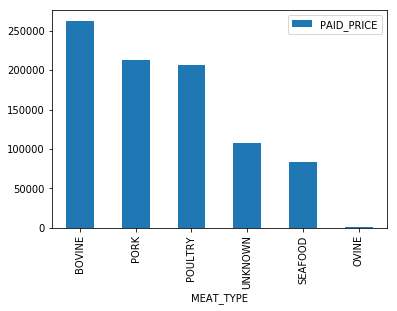

In [3]:
# Get pure meat transactions
pure_meat_transactions = pd.merge(df_transactions,df_pure_meat, on = "PRODUCT_ID", how = "inner")
pure_meat_transactions_type = pure_meat_transactions.groupby("MEAT_TYPE").agg({"PAID_PRICE" : sum})
# Plot
pure_meat_transactions_type.sort_values(by = 'PAID_PRICE',ascending = False).plot.bar();
pure_meat_transactions_type.PAID_PRICE/pure_meat_transactions_type.PAID_PRICE.sum()
df_pure_meat.groupby("MEAT_TYPE").count()["PRODUCT_ID"].sort_values(ascending=False)

It can be clearly see that bovine meat is the most popular amongst the consumers, accounting for 30% of the meat spendings. Poultry and pork meat have a very similar spending average, accounting each for 25% of the overall. The less popular meat category is ovine meat with 0.1% of the spendings.

#### Check Meat and Veggies consumed by Extreme Meat Consumers

In [196]:
def get_transactions(spending_type, quantile):
    # Get the transactions of the extreme meat consumers
    quantile = spending_type.quantile(quantile)
    households = spent_by_household[spending_type > quantile].household_key.values
    transactions = df_food_transactions[df_food_transactions.household_key.isin(households)]
    transactions_with_prod_info = pd.merge(transactions, df_products, how="inner")    
    return list(households), transactions_with_prod_info

In [197]:
def describe_meat_consumption(households_ids, households_transactions, category):
    """
    According to the IDs and Transactions of a group a Household (e.g. Extreme meat eaters)
    Show: 
      - their spendings foe each type of meat
      - For each of the meat type, the ration that they consume
    """
    print("DESCRIPTION FOR:", category)
    print("---------------------------")
    print()
    
    # Select only transactions for pure meat producs
    meat_transactions = pd.merge(households_transactions, df_pure_meat, on = "PRODUCT_ID", how = "inner")
    # Compute sum of paid price
    meat_type = meat_transactions.groupby("MEAT_TYPE").agg({"PAID_PRICE" : sum})
    # Compute Ratio spent per meat type
    ratio_meat = meat_type.copy()
    ratio_meat.PAID_PRICE = ratio_meat.PAID_PRICE/pure_meat_transactions_type.PAID_PRICE
    ratio = sum(meat_type.PAID_PRICE)/sum(pure_meat_transactions_type.PAID_PRICE)
    ratio_meat.rename(columns={'PAID_PRICE':'Fraction consumed by {} per meat type'.format(category)}, inplace=True)
    # Plot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
    most_meat_consumers_meat_type.sort_values(by = 'PAID_PRICE',ascending = False).plot.bar(ax = axes[0])
    ratio_meat.sort_values(by = 'Fraction consumed by {} per meat type'.format(category),ascending = False).plot.bar(ax = axes[1]);
#     axes[1].axhline(y=ratio,linewidth=2, color='red', label = 'Ratio of meat spending for the {}'.format(category))
    axes[1].set_title('Ratio between money spent in meat overall and for {}'.format(category))
    axes[1].set_title('Ratio of meat spending for the {}'.format(category))
    axes[0].set_title('Money spent on meat by {}'.format(category))
    
    # Select only transactions of extreme meat consumers for Veggies producs
    transactions_veggie = pd.merge(households_transactions, df_veggies_prducts, on = "PRODUCT_ID", how = "inner")

    # Check prcts spent for meat and veggies
    prct_vegg = sum(transactions_veggie.PAID_PRICE)/sum(households_transactions.PAID_PRICE)
    prct_meat = sum(meat_transactions.PAID_PRICE)/sum(households_transactions.PAID_PRICE)
    print('Percentage of total money spent on meat {0:.2f} and on vegetables {1:.2f}.'.format(100*prct_meat,100*prct_vegg))
    print()

DESCRIPTION FOR: extreme meat consumers
---------------------------

Percentage of total money spent on meat 38.26 and on vegetables 5.92.



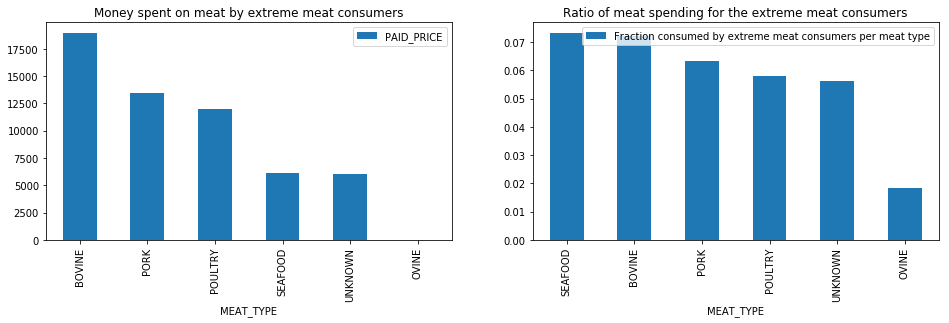

In [198]:
# Get extreme meat consumers transactions and households IDs
extreme_meat_consumers, extreme_meat_consumers_transactions = get_transactions(spent_by_household.ratio_spent_for_meat,
                                                                               quantile=0.95
                                                                              )
describe_meat_consumption(extreme_meat_consumers, extreme_meat_consumers_transactions, "extreme meat consumers")

We can see that extreme meat buyers 

#### Check Meat and Veggies consumed by Extreme Veggies Consumers

DESCRIPTION FOR: extreme veggie consumers
---------------------------

Percentage of total money spent on meat 14.28 and on vegetables 18.05.



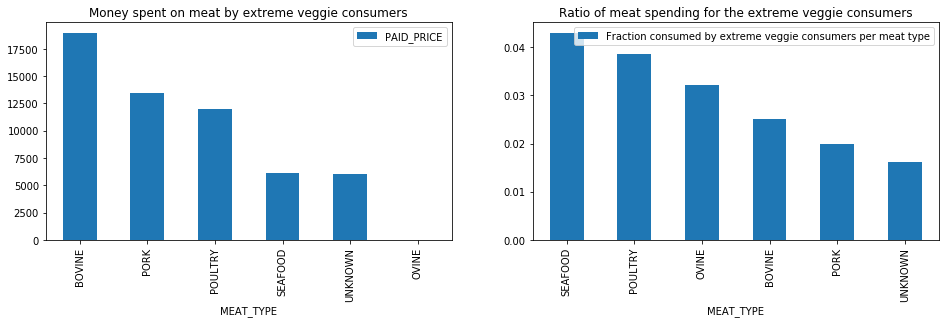

In [199]:
# Get extreme veggies consumers transactions and households IDs
extreme_veggie_buyers, extreme_veggie_consumers_transactions = get_transactions(
    spent_by_household.ratio_spent_for_veggies, quantile=0.95)

describe_meat_consumption(extreme_veggie_buyers, extreme_veggie_consumers_transactions, "extreme veggie consumers")

#### Check Intersection betweem extreme meat buyers and extreme veggies buyers

In [10]:
households_in_both = list(set(extreme_meat_consumers).intersection(extreme_veggie_buyers))
print(f"Out of those {len(extreme_veggie_buyers)} household, {len(households_in_both)} of them (={round((len(households_in_both) / len(extreme_meat_consumers)) * 100, 2)}%) are both extreme meat buyers and extreme veggies buyers.")

Out of those 122 household, 1 of them (=0.82%) are both extreme meat buyers and extreme veggies buyers.


We only consider households that appear in one of the two groups. Doing that we have two disting groups of people.

In [11]:
# Remove houselds that are in the two groups
extreme_meat_consumers_transactions = extreme_meat_consumers_transactions[~extreme_meat_consumers_transactions.household_key.isin(households_in_both)]
extreme_veggie_consumers_transactions = extreme_veggie_consumers_transactions[~extreme_veggie_consumers_transactions.household_key.isin(households_in_both)]

### Compare the most common sub commodities for extreme meat consumers and extreme vegetables consumers 

In [282]:
def compare_two_groups(group1, group2, column, top=20):
    """
    Return the the Top 15 most common sub commodities or commodities (depending on the colum arg.)
    for each of the 2 groups.
    And plot it.
    """
    
    group1_df, group1_name = group1
    group2_df, group2_name = group2
    
    print("%d most common %s for %s and %s" % (top, column, group1_name, group2_name))
    print("-----------------------------------------------------------------------------------")
    
    top_20_g1 = group1_df.groupby(column)["PAID_PRICE"]\
                                       .sum()\
                                       .sort_values(ascending=False)[:top]
    top_20_g2 = group2_df.groupby(column)["PAID_PRICE"]\
                                         .sum()\
                                         .sort_values(ascending=False)[:top]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
    top_20_g1.plot.bar(ax=axes[0]);
    top_20_g2.plot.bar(ax=axes[1]);
    axes[0].set_title("Most Common {} for {}".format(column, group1_name));
    axes[1].set_title("Most Common {} for {}".format(column, group2_name));
    
    return top_20_g1, top_20_g2

20 most common SUB_COMMODITY_DESC for extreme meat consumers and extreme veggies consumers
-----------------------------------------------------------------------------------


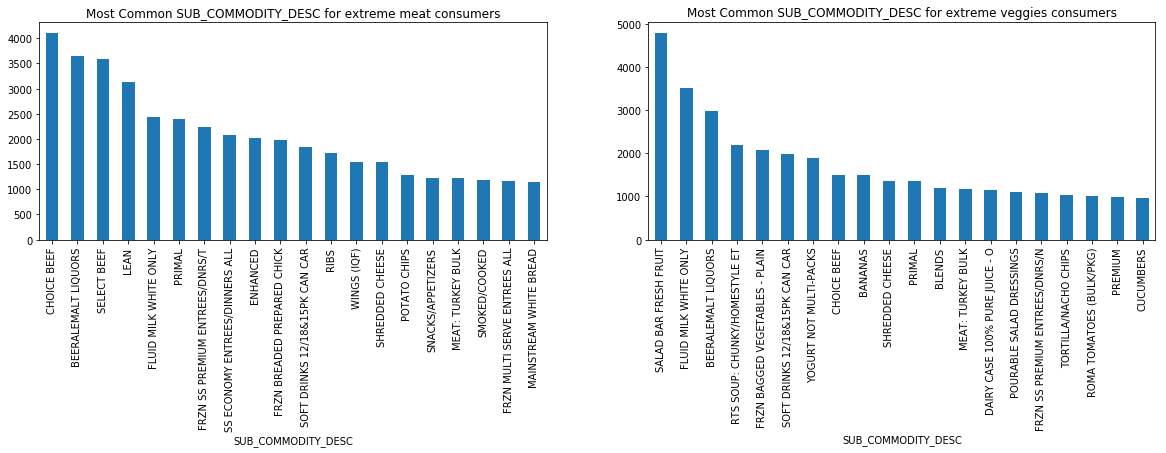

In [283]:
top_20_meat, top_20_veggies = compare_two_groups(
    (extreme_meat_consumers_transactions, "extreme meat consumers"),
    (extreme_veggie_consumers_transactions, "extreme veggies consumers"),
    "SUB_COMMODITY_DESC"
)

In [348]:
import re
def make_word_cloud(words, top20, color):
    """
    Return a word cloud containing the words
    that are in the the top20 and in the arg. words.
    """
    filtered_words = []
    for sub_commodity, value in zip(top20.index, top20):
        value = round(value)
        words = sub_commodity.strip().split(" ")
#         words = re.split('- |\s', sub_commodity)
        for word in words:

            if word in interesting_words:
                if word == "FRZN": word = "FROZEN"
                if word == "CHICK": word = "CHICKEN"
                if word == "BEERALEMALT": word = "BEER"
                if word == "SEAFOOD-FRZ-IQF": word = "SEAFOOD"
                for _ in range(value):
                    filtered_words.append(word)
    wordcloud = WordCloud(background_color='white', color_func=lambda *args, **kwargs: color, width=1000, height=500, collocations = False)
    return wordcloud.generate(" ".join(filtered_words))

def plot_word_clouds(intersesting_words, words1, words2, colors):
    """
    Plot a Word Cloud.
    """
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10))

    wordcloud_meat = make_word_cloud(interesting_words, words1, colors[0])
    wordcloud_veggies = make_word_cloud(interesting_words, words2, colors[1])

    axes[0].imshow(wordcloud_meat)
    axes[1].imshow(wordcloud_veggies)
    axes[0].axis('off')
    axes[1].axis('off')

In [322]:
interesting_words = [
    "BEEF",
    "TORTILLA"
    "LIQUORS",
    "LEAN",
    "MILK",
    "PRIMAL",
    "FRZN",
    "RIBS",
    "WINGS",
    "CHEESE",
    "CHIPS",
    "SNACKS",
    "TURKEY",
    "BREAD",
    "SALAD",
    "FRESH",
    "FRUIT",
    "SOUP:",
    "MEAT:",
    "VEGETABLES",
    "CAN",
    "YOGURT",
    "BANANAS",
    "DAIRY",
    "TOMATOES",
    "CUCUMBERS",
    "JUICE"
]

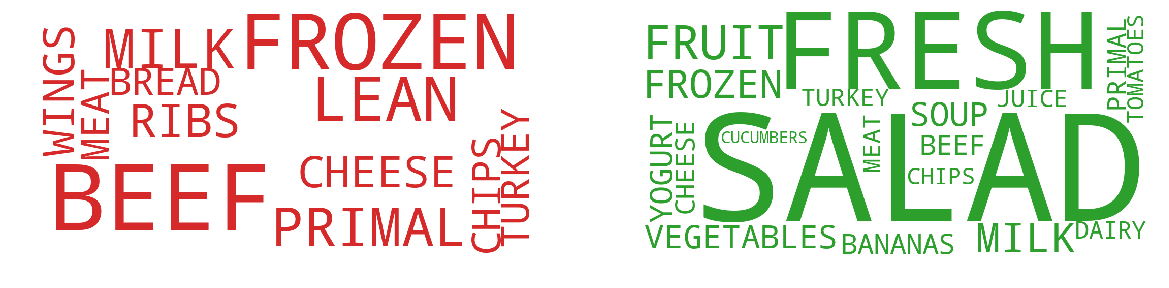

In [323]:
plot_word_clouds(interesting_words, top_20_meat, top_20_veggies, colors=["rgb(214, 41, 42)", "rgb(45, 159, 45)"])

### Compare the most common sub commodities for young and old people

In [324]:
young_houeholds_keys = df_demog[df_demog.AGE_DESC.isin(["19-24", "25-34"])].household_key.values
old_houeholds_keys = df_demog[df_demog.AGE_DESC.isin(["55-64", "65+"])].household_key.values

In [325]:
def get_transactions(transactions_df, households_keys):
    """
    Returns the of the households in households_keys transactions from transactions_df
    """
    transactions = transactions_df[transactions_df.household_key.isin(households_keys)]
    transactions = pd.merge(transactions, df_products, how="inner") 
    return transactions

In [326]:
young_consumers_transactions = get_transactions(df_food_transactions, young_houeholds_keys)
old_consumers_transactions = get_transactions(df_food_transactions, old_houeholds_keys)

young_consumers_meat_transactions = get_transactions(df_pure_meat_transactions, young_houeholds_keys)
old_consumers_meat_transactions = get_transactions(df_pure_meat_transactions, old_houeholds_keys)

20 most common SUB_COMMODITY_DESC for youngest consumers and oldest consumers
-----------------------------------------------------------------------------------


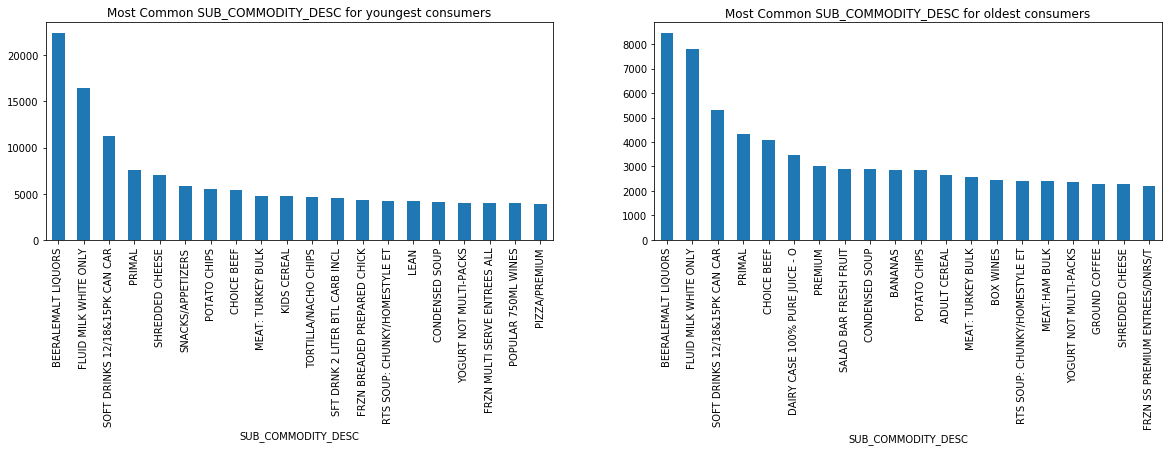

In [327]:
top_20_youngs, top_20_olds = compare_two_groups(
    (young_consumers_food_transactions, "youngest consumers"),
    (old_consumers_food_transactions, "oldest consumers"),
    "SUB_COMMODITY_DESC"
)

In [328]:
interesting_words = [
    "BEERALEMALT",
    "MILK",
    "CAN",
    "PRIMAL",
    "CHEESE",
    "SNACKS/APPETIZERS",
    "CHIPS",
    "BEEF",
    "TURKEY",
    "CEREAL",
    "PREPARED",
    "SOUP",
    "YOGURT",
    "FRZN",
    "LEAN",
    "WINES",
    "PIZZA/PREMIUM",
    "JUICE",
    "PREMIUM",
    "SALAD",
    "FRESH",
    "FRUIT",
    "BANANAS",
    "TURKEY",
    "HAM",
    "COFFEE"
]

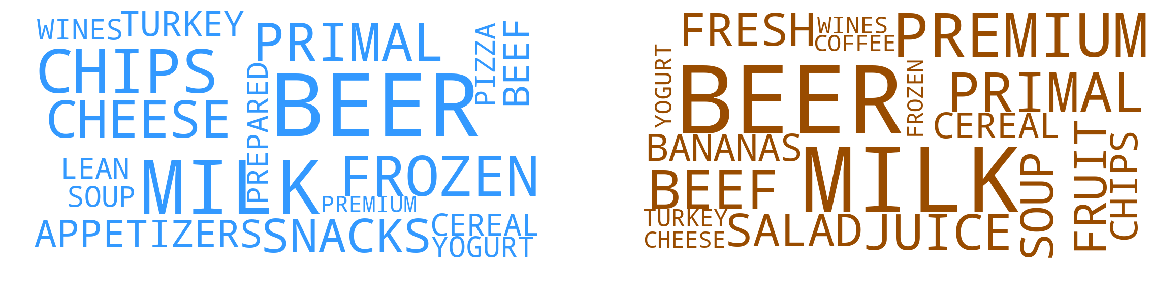

In [329]:
plot_word_clouds(interesting_words, top_20_youngs, top_20_olds, colors=["rgb(51, 153, 255)", "rgb(153, 76, 0)"])

### Compare the most common MEAT-RELATED sub commodities for young and old peoples

20 most common SUB_COMMODITY_DESC for Youngest consumers and Oldest consumers
-----------------------------------------------------------------------------------


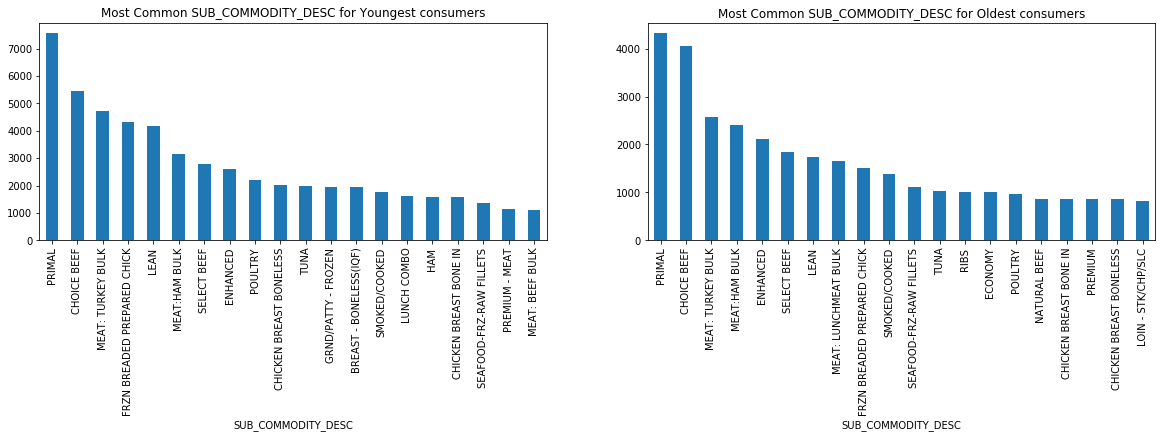

In [330]:
top_20_youngs_meat, top_20_olds_meat = compare_two_groups(
    (young_consumers_meat_transactions, "Youngest consumers"),
    (old_consumers_meat_transactions, "Oldest consumers"),
    "SUB_COMMODITY_DESC"
)

In [331]:
interesting_words = [
    "PRIMAL",
    "BEEF",
    "TURKEY",
    "CHICK",
    "LEAN",
    "HAM",
    "BEEF",
    "POULTRY",
    "CHICKEN",
    "TUNA",
    "RIBS"
]

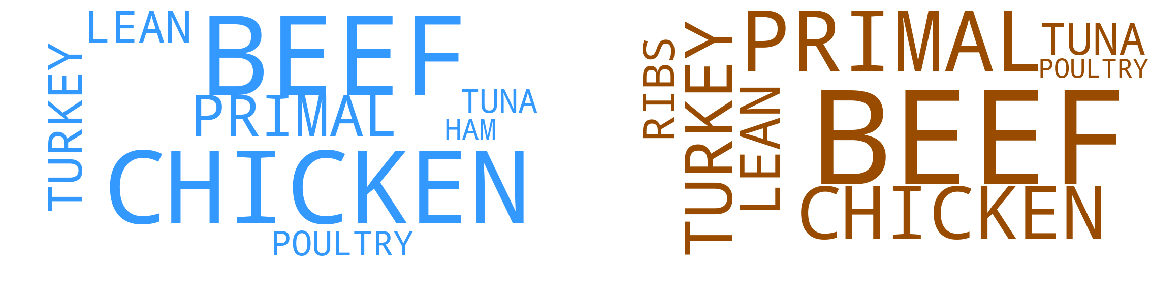

In [332]:
plot_word_clouds(interesting_words, top_20_youngs_meat, top_20_olds_meat, colors=["rgb(51, 153, 255)", "rgb(153, 76, 0)"])

### Compare the most common sub commodities for poor and rich

In [333]:
poor_houeholds_keys = df_demog[df_demog.INCOME_DESC.isin(["35-49K"])].household_key.values
rich_houeholds_keys = df_demog[df_demog.INCOME_DESC.isin(["100K+"])].household_key.values

In [334]:
poor_consumers_transactions = get_transactions(df_food_transactions, poor_houeholds_keys)
rich_consumers_transactions = get_transactions(df_food_transactions, rich_houeholds_keys)

poor_consumers_meat_transactions = get_transactions(df_pure_meat_transactions, poor_houeholds_keys)
rich_consumers_meat_transactions = get_transactions(df_pure_meat_transactions, rich_houeholds_keys)

20 most common SUB_COMMODITY_DESC for poorest consumers and richest consumers
-----------------------------------------------------------------------------------


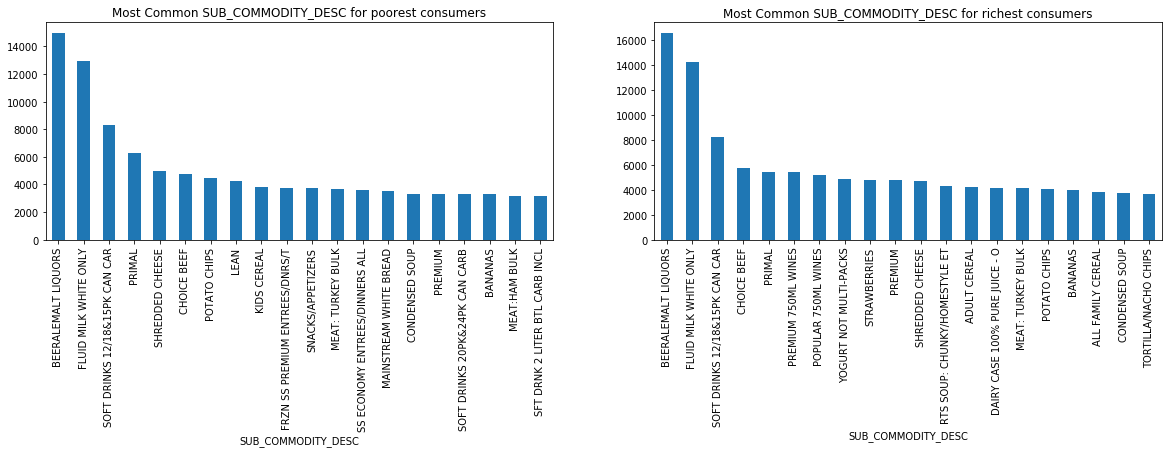

In [335]:
top_20_poor, top_20_rich = compare_two_groups(
    (poor_consumers_transactions, "poorest consumers"),
    (rich_consumers_transactions, "richest consumers"),
    "SUB_COMMODITY_DESC"
)

In [336]:
interesting_words = [
    "PRIMAL",
    "BERRALEMALT",
    "MILL",
    "CAN",
    "PRIMAL",
    "CHEESE",
    "BEEF",
    "CHIPS",
    "LEAN",
    "CEREAL",
    "FRZN",
    "SNACKS/APPETIZERS",
    "TURKEY",
    "BREAD",
    "SOUP",
    "BANANAS",
    "WINES",
    "YOGURT",
    "STRAWBERRIES",
    "CHEESE",
    "JUICE",
    "CHIPS"
]

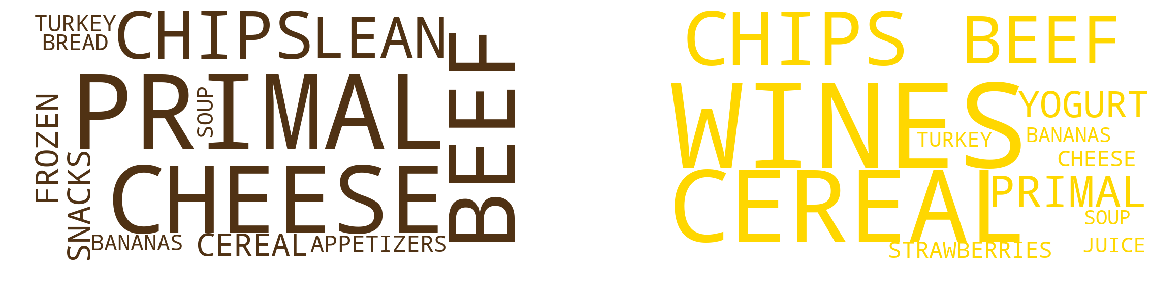

In [337]:
plot_word_clouds(interesting_words, top_20_poor, top_20_rich, colors=["rgb(80, 50, 20)", "rgb(255,215,0)"])

### Compare the most common MEAT-RELATED sub commodities for poor and rich peoples

20 most common SUB_COMMODITY_DESC for poorest consumers and richest consumers
-----------------------------------------------------------------------------------


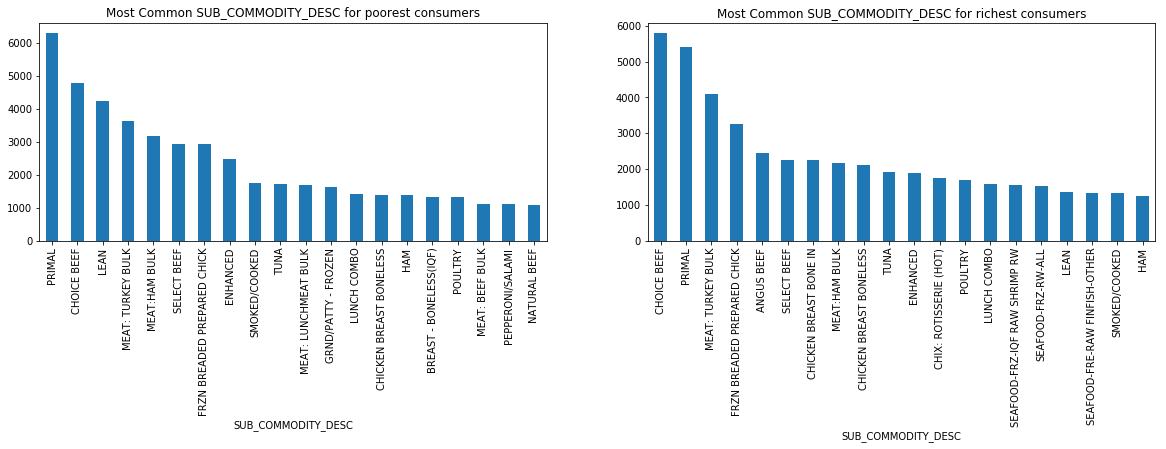

In [338]:
top_20_poor_meat, top_20_rich_meat = compare_two_groups(
    (poor_consumers_meat_transactions, "poorest consumers"),
    (rich_consumers_meat_transactions, "richest consumers"),
    "SUB_COMMODITY_DESC"
)

In [353]:
interesting_words = [
    "PRIMAL",
    "BEEF",
    "FROZEN",
    "BREAST",
    "POULTRY",
    "PEPPERONI/SALAMI",
    "ANGUS",
    "ROTISSERIE",
    "TURKEY",
    "CHICK",
    "LEAN",
    "HAM",
    "BEEF",
    "POULTRY",
    "CHICKEN",
    "TUNA",
    "RIBS"
    "SEAFOOD-FRZ-IQF",
    "SEAFOOD-FRZ-RW-ALL",
    "SEAFOOD-FRE-RAW",
]

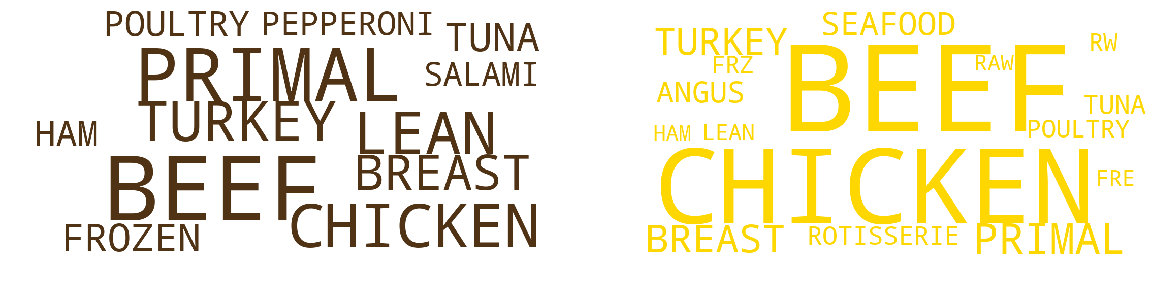

In [354]:
plot_word_clouds(interesting_words, top_20_poor_meat, top_20_rich_meat, colors=["rgb(80, 50, 20)", "rgb(255,215,0)"])

### Compare 2 groups on some selected commodities

In [382]:
# selected_commodities = [
#     "FRUIT - SHELF STABLE",
#     "SOFT DRINKS",
#     "BAG SNACKS",
#     "YOGURT",
#     "CHEESE",
#     "FLUID MILK PRODUCTS",
#     "COFFEE",
#     "TEAS",
#     "VEGETABLES - SHELF STABLE",
#     "BEEF",
# ]

selected_commodities = list(df_meat_transactions.COMMODITY_DESC.values)

def get_count_by_commodity(df, commodities):
    filtered = df[df.COMMODITY_DESC.isin(commodities)]
    return filtered[["COMMODITY_DESC"]].reset_index().groupby("COMMODITY_DESC")["index"].count().reset_index(name="count")

def compare_groups_on_selected_commodidies(g1_transactions, g2_transactions, g1_name, g2_name, g1_size, g2_size):
    counts_per_commodity_g1 = get_count_by_commodity(g1_transactions, selected_commodities)
    counts_per_commodity_g2 = get_count_by_commodity(g2_transactions, selected_commodities)
    counts_per_commodity_g1["Number of transaction per housold"] = counts_per_commodity_g1["count"]/g1_size
    counts_per_commodity_g2["Number of transaction per housold"] = counts_per_commodity_g2["count"]/g2_size

    counts_per_commodity_g1['hue'] = g1_name
    counts_per_commodity_g2['hue'] = g2_name
    res=pd.concat([counts_per_commodity_g1, counts_per_commodity_g2])

    plt.figure(figsize=(20,5))
    plt.title ("{} vs {}".format(g1_name, g2_name))
    plot = sns.barplot(x='COMMODITY_DESC',y='Number of transaction per housold',data=res,hue='hue')
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plt.show()

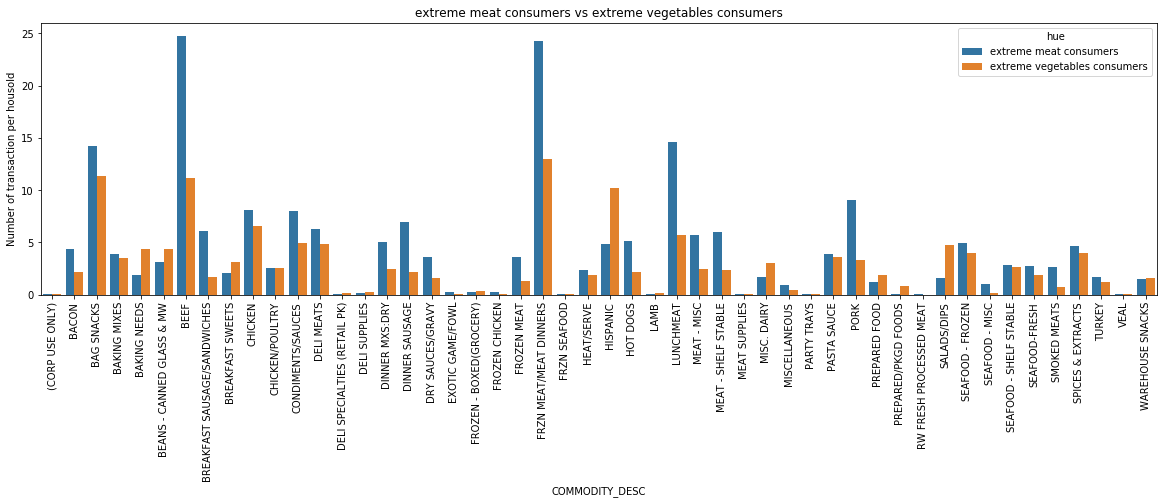

In [383]:
compare_groups_on_selected_commodidies(extreme_meat_consumers_transactions, extreme_veggie_consumers_transactions, "extreme meat consumers", "extreme vegetables consumers", len(extreme_meat_consumers), len(extreme_veggie_buyers))

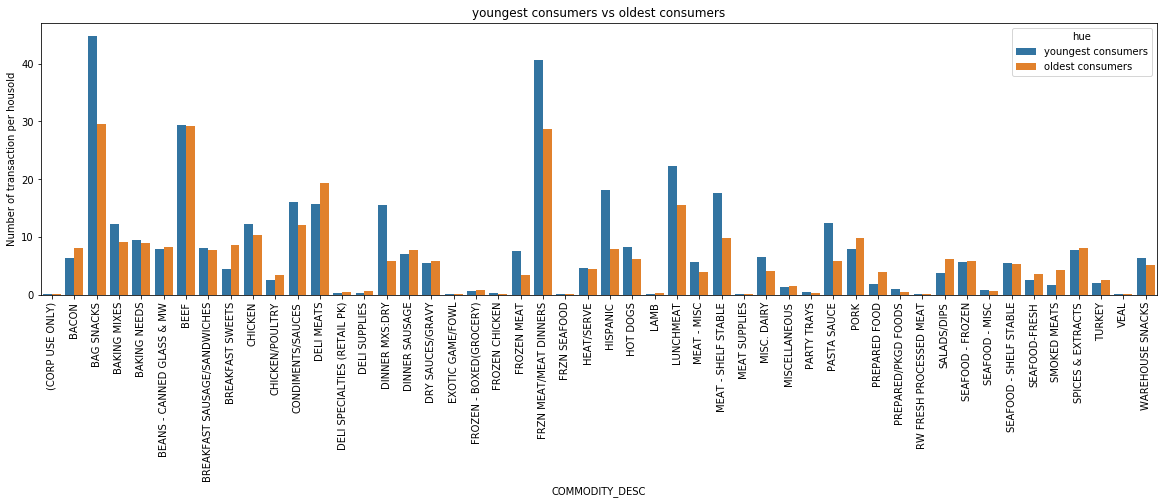

In [384]:
compare_groups_on_selected_commodidies(young_consumers_transactions, old_consumers_transactions, "youngest consumers", "oldest consumers", len(young_houeholds_keys), len(old_houeholds_keys))

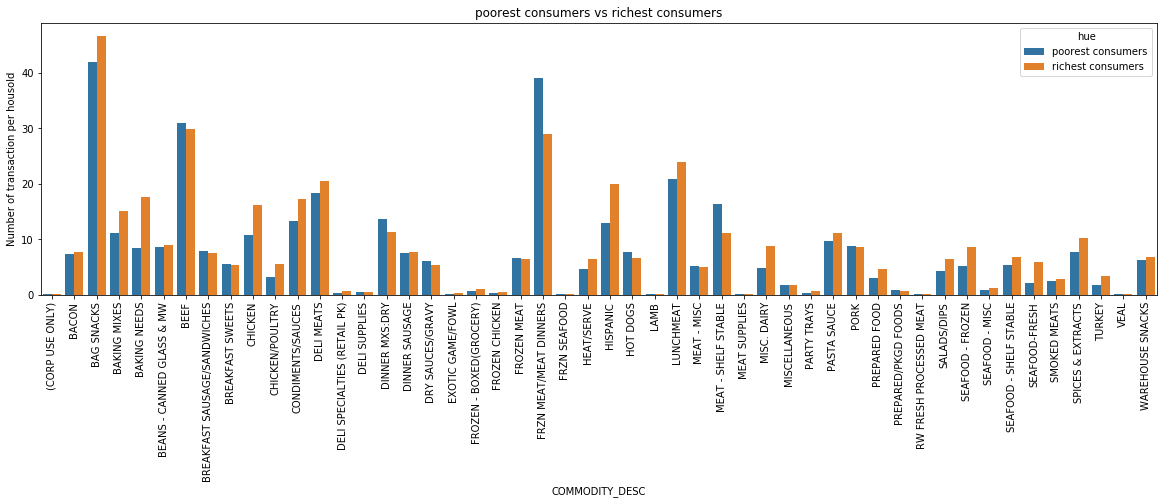

In [385]:
compare_groups_on_selected_commodidies(poor_consumers_transactions, rich_consumers_transactions, "poorest consumers", "richest consumers", len(poor_houeholds_keys), len(rich_houeholds_keys))